# Birdie Model(Default Pretraining)

## Data Loader

In [4]:
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=16000, duration=5):
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')]
        self.sample_rate = sample_rate
        self.samples = sample_rate * duration

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.file_paths[idx])
        waveform = torchaudio.functional.resample(waveform, orig_freq=sr, new_freq=self.sample_rate)
        waveform = waveform.mean(dim=0)
        if waveform.size(0) < self.samples:
            waveform = torch.nn.functional.pad(waveform, (0, self.samples - waveform.size(0)))
        else:
            waveform = waveform[:self.samples]
        return waveform


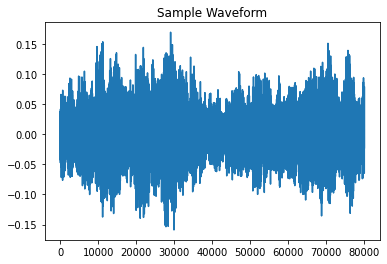

In [5]:
# Your dataset path
dataset_path = "data/genres_original/classical"

# Load dataset
dataset = AudioDataset(data_dir=dataset_path)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# (Optional) Plot a sample
waveform = dataset[0]
plt.plot(waveform.numpy())
plt.title("Sample Waveform")
plt.show()


## Birdie Model (Simple SSM-style VAE)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class BirdieVAE(nn.Module):
    def __init__(self, input_dim=80000, hidden_dim=512, latent_dim=128):
        super(BirdieVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## Train Function

In [7]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

def train(model, dataloader, epochs=10, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(torch.float32).to('cpu')
            batch = batch.view(batch.size(0), -1)
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


In [8]:
model = BirdieVAE(input_dim=16000 * 5)  # 5 seconds of audio at 16kHz
train(model, dataloader, epochs=10)


Epoch 1, Loss: 268162.96
Epoch 2, Loss: 447096.10
Epoch 3, Loss: 135092.80
Epoch 4, Loss: 76870.48
Epoch 5, Loss: 58254.52
Epoch 6, Loss: 51088.22
Epoch 7, Loss: 48654.98
Epoch 8, Loss: 45372.71
Epoch 9, Loss: 81564.38
Epoch 10, Loss: 52640.98


## Generate Sample

In [11]:
def generate_sample(model, output_path='generated_default.wav', sr=16000):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, 128)
        sample = model.decode(z).view(-1).cpu().numpy()
        torchaudio.save(output_path, torch.tensor([sample]), sample_rate=sr)

# Call it:
generate_sample(model, output_path='generated_default.wav')



In [12]:
from IPython.display import Audio

# Play the generated audio
Audio("generated_default.wav")

# Selective Copying

In [13]:
def selective_copying_loss(pred, target, mask):
    # Only compute loss where mask == 1 (i.e., where copying is required)
    return F.mse_loss(pred[mask], target[mask])


In [14]:
class CopyingDataset(AudioDataset):
    def __getitem__(self, idx):
        waveform = super().__getitem__(idx)
        mask = torch.zeros_like(waveform, dtype=torch.bool)
        # Randomly choose a segment to copy (e.g., middle 1 sec)
        start = waveform.shape[0] // 3
        end = start + waveform.shape[0] // 5
        mask[start:end] = 1
        target = waveform.clone()
        waveform[start:end] = 0  # zero-out copy span
        return waveform, target, mask


In [15]:
def train_selective_copying(model, dataloader, epochs=10, lr=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        for batch, target, mask in dataloader:
            batch = batch.view(batch.size(0), -1)
            target = target.view(target.size(0), -1)
            mask = mask.view(mask.size(0), -1)
            recon, mu, logvar = model(batch)
            loss = selective_copying_loss(recon, target, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Selective Copying] Epoch {epoch+1}, Loss: {total_loss:.2f}")


In [16]:
# Step 1: Load Dataset
copy_dataset = CopyingDataset(data_dir="data/genres_original/classical", sample_rate=16000, duration=5)
copy_dataloader = DataLoader(copy_dataset, batch_size=8, shuffle=True)

# Step 2: Initialize the Model
input_dim = 16000 * 5  # 5 seconds at 16kHz
model = BirdieVAE(input_dim=input_dim, hidden_dim=512, latent_dim=128)

# Step 3: Train with Selective Copying
train_selective_copying(model, copy_dataloader, epochs=10)


[Selective Copying] Epoch 1, Loss: 0.41
[Selective Copying] Epoch 2, Loss: 0.30
[Selective Copying] Epoch 3, Loss: 0.09
[Selective Copying] Epoch 4, Loss: 0.07
[Selective Copying] Epoch 5, Loss: 0.05
[Selective Copying] Epoch 6, Loss: 0.05
[Selective Copying] Epoch 7, Loss: 0.05
[Selective Copying] Epoch 8, Loss: 0.05
[Selective Copying] Epoch 9, Loss: 0.05
[Selective Copying] Epoch 10, Loss: 0.05


In [17]:
def generate_sample_selective(model, output_path='generated_selective.wav', sr=16000):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, 128)  # match latent_dim
        sample = model.decode(z).view(-1).cpu()

        # Optional: normalize audio
        sample = sample / sample.abs().max()

        # Save as WAV
        torchaudio.save(output_path, sample.unsqueeze(0), sample_rate=sr)


In [18]:
# Generate audio sample
generate_sample_selective(model, output_path='generated_selective.wav')


In [19]:
from IPython.display import Audio

# Play the generated audio
Audio("generated_default.wav")